# Lectures 7: Class demo

### Imports

In [3]:
import os
import sys

sys.path.append(os.path.join(os.path.abspath(".."), (".."), "code"))
from utils import *
import matplotlib.pyplot as plt
import mglearn
import numpy as np
import pandas as pd
from plotting_functions import *
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
%matplotlib inline
DATA_DIR = os.path.join(os.path.abspath(".."), (".."), "data/")
pd.set_option("display.max_colwidth", 200)

## Demo: Model interpretation of linear classifiers

- One of the primary advantage of linear classifiers is their ability to interpret models. 
- For example, with the sign and magnitude of learned coefficients we could answer questions such as which features are driving the prediction to which direction. 

- We'll demonstrate this by training `LogisticRegression` on the famous [IMDB movie review](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) dataset. The dataset is a bit large for demonstration purposes. So I am going to put a big portion of it in the test split to speed things up. 

In [6]:
imdb_df = pd.read_csv(DATA_DIR + "imdb_master.csv", encoding="ISO-8859-1")
imdb_df.head()

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me...",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire p...",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue i...",positive
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenl...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what mone...",positive


Let's clean up the data a bit. 

In [10]:
import re

def replace_tags(doc):
    doc = doc.replace("<br />", " ")
    doc = re.sub(r"https://\S*", "", doc)
    return doc

In [11]:
imdb_df["review_pp"] = imdb_df["review"].apply(replace_tags)

Are we breaking the Golden rule here? 

Let's split the data and create bag of words representation. 

In [13]:
train_df, test_df = train_test_split(imdb_df, test_size=0.9, random_state=123)
X_train, y_train = train_df["review_pp"], train_df["sentiment"]
X_test, y_test = test_df["review_pp"], test_df["sentiment"]
train_df.shape

(5000, 3)

In [14]:
vec = CountVectorizer(stop_words="english")
bow = vec.fit_transform(X_train)
bow

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 439384 stored elements and shape (5000, 38867)>

### Examining the vocabulary

- The vocabulary (mapping from feature indices to actual words) can be obtained using `get_feature_names_out()` on the `CountVectorizer` object. 

In [15]:
vocab = vec.get_feature_names_out()

In [16]:
vocab[0:10]  # first few words

array(['00', '000', '007', '0079', '0080', '0083', '00pm', '00s', '01',
       '0126'], dtype=object)

In [17]:
vocab[2000:2010]  # some middle words

array(['apprehensive', 'apprentice', 'approach', 'approached',
       'approaches', 'approaching', 'appropriate', 'appropriated',
       'appropriately', 'approval'], dtype=object)

In [18]:
vocab[::500]  # words with a step of 500

array(['00', 'aaja', 'affection', 'ambrosine', 'apprehensive', 'attract',
       'barbara', 'bereavement', 'blore', 'brazenly', 'businessman',
       'carrel', 'chatterjee', 'claudio', 'commanding', 'consumed',
       'cramped', 'cynic', 'defining', 'deviates', 'displaced',
       'dramatized', 'edie', 'enforced', 'evolving', 'fanatically',
       'fingertips', 'formal', 'gaffers', 'giogio', 'gravitas',
       'halliday', 'heist', 'hoot', 'iliad', 'infiltrate', 'investment',
       'jobson', 'kidnappee', 'landsbury', 'licentious', 'lousiest',
       'malã', 'maã', 'mice', 'molla', 'museum', 'newtonian',
       'obsessiveness', 'outbursts', 'parapsychologist', 'perpetuates',
       'plasters', 'powers', 'property', 'rabies', 'reclined', 'renters',
       'ridiculous', 'rube', 'sayid', 'select', 'shivers', 'skinheads',
       'sohail', 'spot', 'stomaches', 'suitcase', 'syrupy', 'terrorist',
       'tolerance', 'triangular', 'unbidden', 'unrevealed', 'verneuil',
       'walrus', 'wilcox',

In [19]:
y_train.value_counts()

sentiment
positive    2517
negative    2483
Name: count, dtype: int64

### Model building on the dataset 

First let's try `DummyClassifier` on the dataset. 

In [20]:
dummy = DummyClassifier()
scores = cross_validate(dummy, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.032334,0.002575,0.504,0.50325
1,0.002154,0.001422,0.504,0.50325
2,0.001573,0.001386,0.503,0.50350
3,0.001617,0.001429,0.503,0.50350
4,0.001399,0.001153,0.503,0.50350


We have a balanced dataset. So the `DummyClassifier` score is around 0.5. 

Now let's try logistic regression. 

In [21]:
pipe_lr = make_pipeline(
    CountVectorizer(stop_words="english"),
    LogisticRegression(max_iter=1000),
)
scores = cross_validate(pipe_lr, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.446221,0.058952,0.828,0.99975
1,0.414545,0.061613,0.830,0.99975
2,0.431959,0.059685,0.848,0.99975
3,0.401264,0.058604,0.833,1.00000
4,0.400344,0.058320,0.840,0.99975


Seems like we are overfitting. Let's optimize the hyperparameter `C` of LR and `max_features` of `CountVectorizer`. 

In [25]:
scores_dict = {
    "C": 10.0 ** np.arange(-3, 3, 1),
    "mean_train_scores": list(),
    "mean_cv_scores": list(),
}
for C in scores_dict["C"]:
    pipe_lr = make_pipeline(CountVectorizer(max_features=10_000, stop_words="english"),
                        LogisticRegression(max_iter=1000, C=C)
                       )
    scores = cross_validate(pipe_lr, X_train, y_train, return_train_score=True)
    scores_dict["mean_train_scores"].append(scores["train_score"].mean())
    scores_dict["mean_cv_scores"].append(scores["test_score"].mean())

results_df = pd.DataFrame(scores_dict)
results_df

,C,mean_train_scores,mean_cv_scores
0,0.001,0.82615,0.7864
1,0.010,0.91795,0.8322
2,0.100,0.98570,0.8422
3,1.000,0.99980,0.8340
4,10.000,1.00000,0.8256
5,100.000,1.00000,0.8312


In [33]:
optimized_C = results_df["C"][results_df["mean_cv_scores"].idxmax()]
print(
    "The maximum validation score is %0.3f at C = %0.2f "
    % (
        np.max(results_df["mean_cv_scores"]),
        optimized_C,
    ))

The maximum validation score is 0.842 at C = 0.10 


In [34]:
pipe_lr = make_pipeline(CountVectorizer(max_features=10000, stop_words="english"),
                        LogisticRegression(max_iter=1000, C = 0.10)
                       )
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=10000, stop_words='english')),
                ('logisticregression',
                 LogisticRegression(C=0.1, max_iter=1000))])

### Examining learned coefficients 

- The learned coefficients are exposed by the `coef_` attribute of [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) object. 

In [35]:
# Get feature names
feature_names = pipe_lr.named_steps['countvectorizer'].get_feature_names_out().tolist()

# Get coefficients 
coeffs = pipe_lr.named_steps["logisticregression"].coef_.flatten()

In [36]:
word_coeff_df = pd.DataFrame(coeffs, index=feature_names, columns=["Coefficient"])
word_coeff_df

,Coefficient
00,0.058621
000,0.075009
007,0.005351
10,0.184220
100,-0.067604
...,...
zone,0.000927
zoo,-0.069953
zorro,0.041716
zu,0.072167


- Let's sort the coefficients in descending order. 
- Interpretation
    - if $w_j > 0$ then increasing $x_{ij}$ moves us toward predicting $+1$. 
    - if $w_j < 0$ then increasing $x_{ij}$ moves us toward predicting $-1$. 


In [37]:
word_coeff_df.sort_values(by="Coefficient", ascending=False)

,Coefficient
excellent,0.794894
amazing,0.622091
perfect,0.608633
wonderful,0.571676
great,0.535896
...,...
waste,-0.683588
terrible,-0.719606
boring,-0.725668
awful,-0.872302


- The coefficients make sense!

Let's visualize the top 20 features.

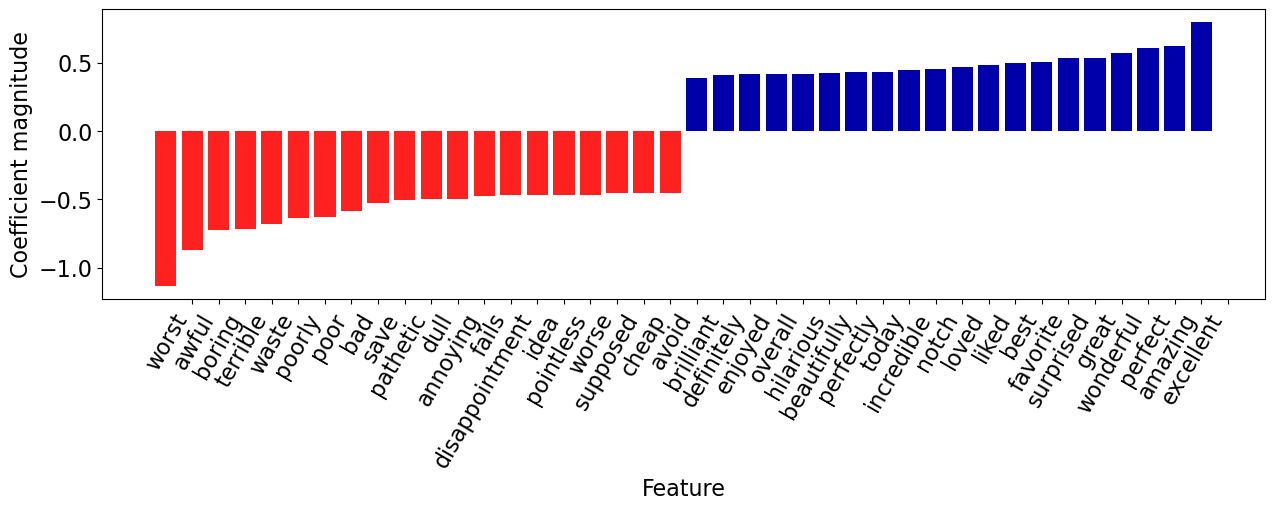

In [38]:
mglearn.tools.visualize_coefficients(coeffs, feature_names, n_top_features=20)

Let's explore prediction of the following new review. 

In [39]:
fake_reviews = ["It got a bit boring at times but the direction was excellent and the acting was flawless. Overall I enjoyed the movie and I highly recommend it!",
 "The plot was shallower than a kiddie pool in a drought, but hey, at least we now know emojis should stick to texting and avoid the big screen."
]

Let's get prediction probability scores of the fake review. 

In [41]:
pipe_lr.predict(fake_reviews)

array(['positive', 'negative'], dtype=object)

In [43]:
# Get prediction probabilities for fake reviews 
pipe_lr.predict_proba(fake_reviews)

array([[0.17333954, 0.82666046],
       [0.68822214, 0.31177786]])

In [44]:
pipe_lr.classes_

array(['negative', 'positive'], dtype=object)

We can find which of the vocabulary words are present in this review:

In [45]:
def plot_coeff_example(model, review, coeffs, feature_names, n_top_feats=6):
    print(review)
    feat_vec = model.named_steps["countvectorizer"].transform([review])
    words_in_ex = feat_vec.toarray().ravel().astype(bool)

    ex_df = pd.DataFrame(
        data=coeffs[words_in_ex],
        index=np.array(feature_names)[words_in_ex],
        columns=["Coefficient"],
    )
    mglearn.tools.visualize_coefficients(
    coeffs[words_in_ex], np.array(feature_names)[words_in_ex], n_top_features=n_top_feats
    )
    return ex_df.sort_values(by=["Coefficient"], ascending=False)

It got a bit boring at times but the direction was excellent and the acting was flawless. Overall I enjoyed the movie and I highly recommend it!


,Coefficient
excellent,0.794894
overall,0.417289
enjoyed,0.416470
highly,0.328111
bit,0.327412
times,0.227090
recommend,0.172985
flawless,0.066854
movie,-0.033348
got,-0.087397


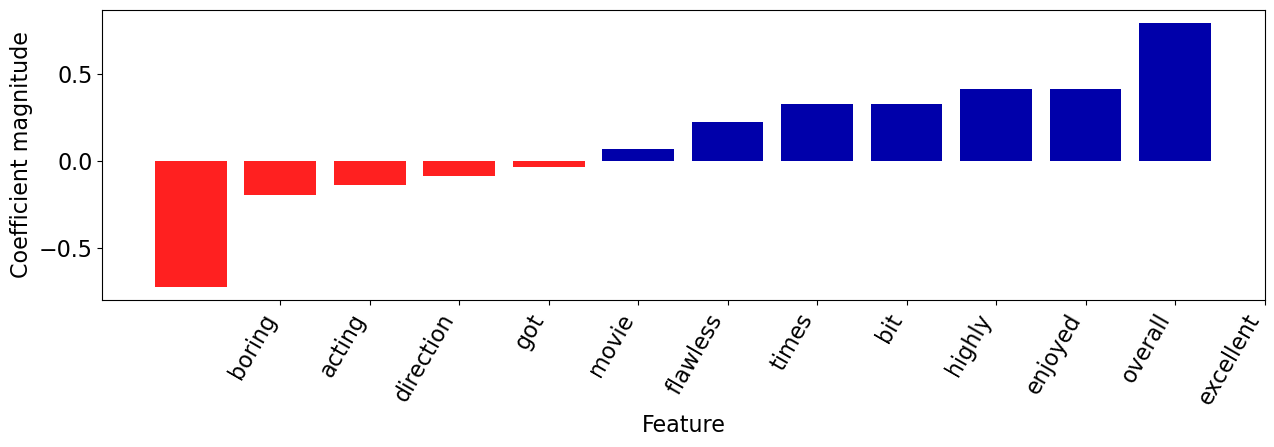

In [47]:
plot_coeff_example(pipe_lr, fake_reviews[0], coeffs, feature_names)

The plot was shallower than a kiddie pool in a drought, but hey, at least we now know emojis should stick to texting and avoid the big screen.


,Coefficient
know,0.225363
stick,0.020377
kiddie,-0.042543
screen,-0.057418
big,-0.059373
hey,-0.066556
pool,-0.090659
plot,-0.254875
avoid,-0.457039


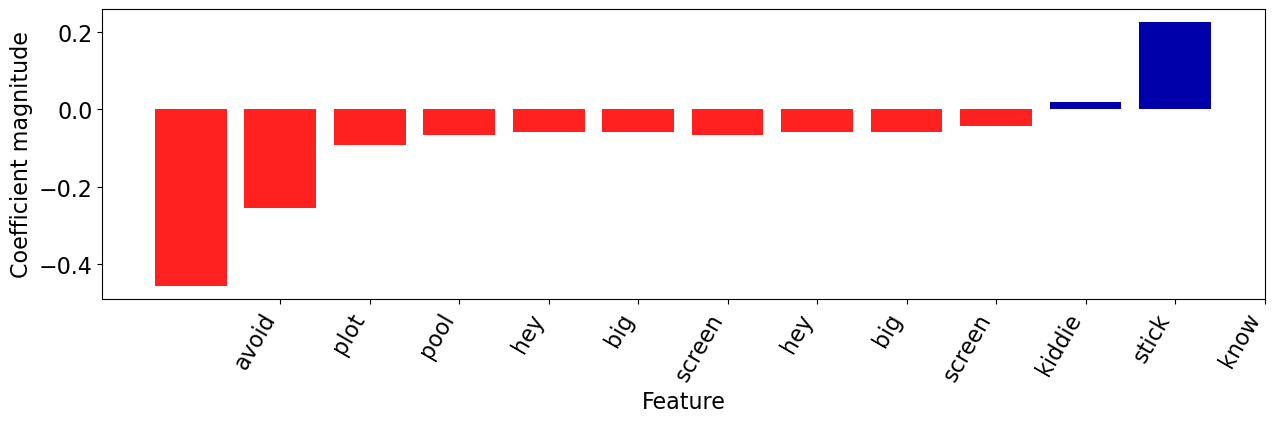

In [49]:
plot_coeff_example(pipe_lr, fake_reviews[1], coeffs, feature_names)

<br><br><br><br>

### Most positive review 

- Remember that you can look at the probabilities (confidence) of the classifier's prediction using the `model.predict_proba` method.
- Can we find the reviews where our classifier is most certain or least certain?

In [50]:
# only get probabilities associated with pos class
pos_probs = pipe_lr.predict_proba(X_train)[
    :, 1
]  # only get probabilities associated with pos class
pos_probs

array([0.97581663, 0.27576982, 0.93402132, ..., 0.75329946, 0.87516818,
       0.00630932])

What's the index of the example where the classifier is most certain (highest `predict_proba` score for positive)?

In [51]:
most_positive_id = np.argmax(pos_probs)

In [53]:
print("True target: %s\n" % (y_train.iloc[most_positive_id]))
print("Predicted target: %s\n" % (pipe_lr.predict(X_train.iloc[[most_positive_id]])[0]))
print("Prediction probability: %0.4f" % (pos_probs[most_positive_id]))

True target: positive

Predicted target: positive

Prediction probability: 1.0000


Let's examine the features associated with the review. 

This is an awesome Amicus horror anthology, with 3 great stories, and fantastic performances!, only the last story disappoints. All the characters are awesome, and the film is quite chilling and suspenseful, plus Peter Cushing and Christopher Lee are simply amazing in this!. It's very underrated and my favorite story has to be the 3rd one "Sweets To The Sweet", plus all the characters are very likable. Some of it's predictable, and the last story was incredibly disappointing and rather bland!, however the ending was really cool!. This is an awesome Amicus horror anthology, with 3 great stories, and fantastic performances, only the last story disappoints!, i say it's must see!.  1st Story ("Method for Murder"). This is an awesome story, with plenty of suspense, and the killer Dominic is really creepy, and it's very well acted as well!. This was the perfect way to start off with a story, and for the most part it's unpredictable, plus the double twist ending is shocking, and quite creepy!

,Coefficient
excellent,0.794894
amazing,0.622091
perfect,0.608633
wonderful,0.571676
great,0.535896
...,...
accent,-0.347124
couldn,-0.374866
disappointing,-0.383650
dull,-0.501351


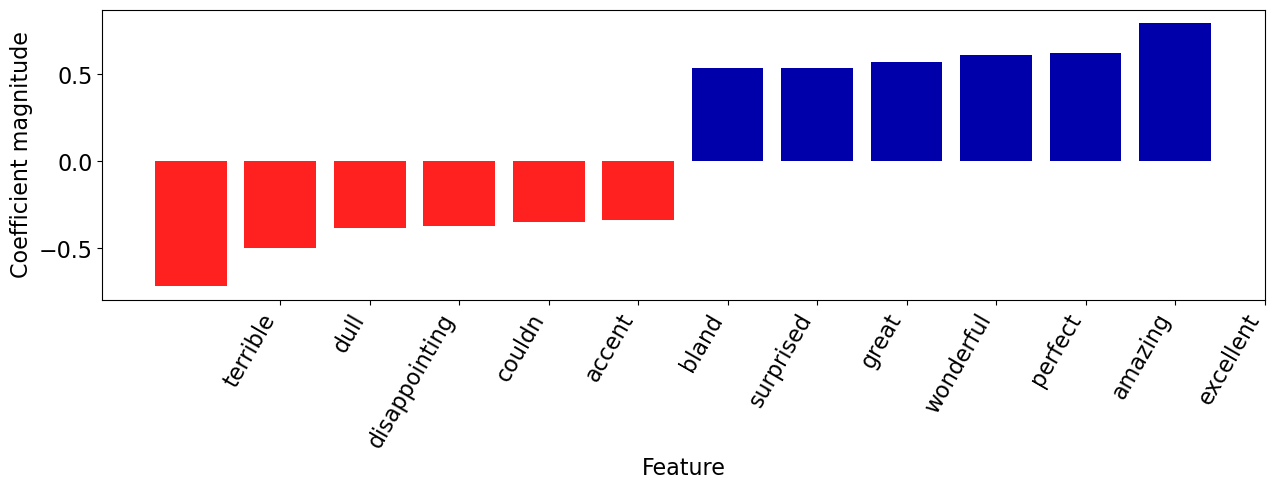

In [55]:
plot_coeff_example(pipe_lr, X_train.iloc[most_positive_id], coeffs, feature_names)

The review has both positive and negative words but the words with **positive** coefficients win in this case! 

### Most negative review 

In [56]:
neg_probs = pipe_lr.predict_proba(X_train)[
    :, 0
]  # only get probabilities associated with neg class
neg_probs

array([0.02418337, 0.72423018, 0.06597868, ..., 0.24670054, 0.12483182,
       0.99369068])

In [57]:
most_negative_id = np.argmax(neg_probs)

In [59]:
print("Review: %s\n" % (X_train.iloc[[most_negative_id]]))
print("True target: %s\n" % (y_train.iloc[most_negative_id]))
print("Predicted target: %s\n" % (pipe_lr.predict(X_train.iloc[[most_negative_id]])[0]))
print("Prediction probability: %0.4f" % (neg_probs[most_negative_id]))

Review: 13452    Zombi 3 starts as a group of heavily armed men steal a experimental chemical developed to reanimate the dead, while trying to escape the man is shot at & the metal container holding the chemical i...
Name: review_pp, dtype: object

True target: negative

Predicted target: negative

Prediction probability: 1.0000


Zombi 3 starts as a group of heavily armed men steal a experimental chemical developed to reanimate the dead, while trying to escape the man is shot at & the metal container holding the chemical is breached. The man gets some of the green chemical on a wound on his hand which soon after turns him into a flesh eating cannibalistic zombie. Within hours the surrounding area is crawling with the flesh easting undead on the look out for fresh victims, Kenny (Deran Sarafian) & his army buddies find themselves in big trouble as they stop to help Patricia (Beatrice Ring) & her friend Lia (Deborah Bergammi) who has been pecked by zombie birds (!). General Morton is in charge of the situation & has to stop the zombie plague from spread throughout the whole world! But will he & his men succeed?  This Italian produced film was to be directed by Italian zombie gore film auteur Lucio Fulci but the story goes he suffered a stroke & therefore couldn't finish the film so producer Franco Gaudenzi asked 

,Coefficient
fun,0.387537
makes,0.374170
entertaining,0.336846
late,0.264844
escape,0.237104
...,...
bad,-0.585101
poor,-0.632143
terrible,-0.719606
boring,-0.725668


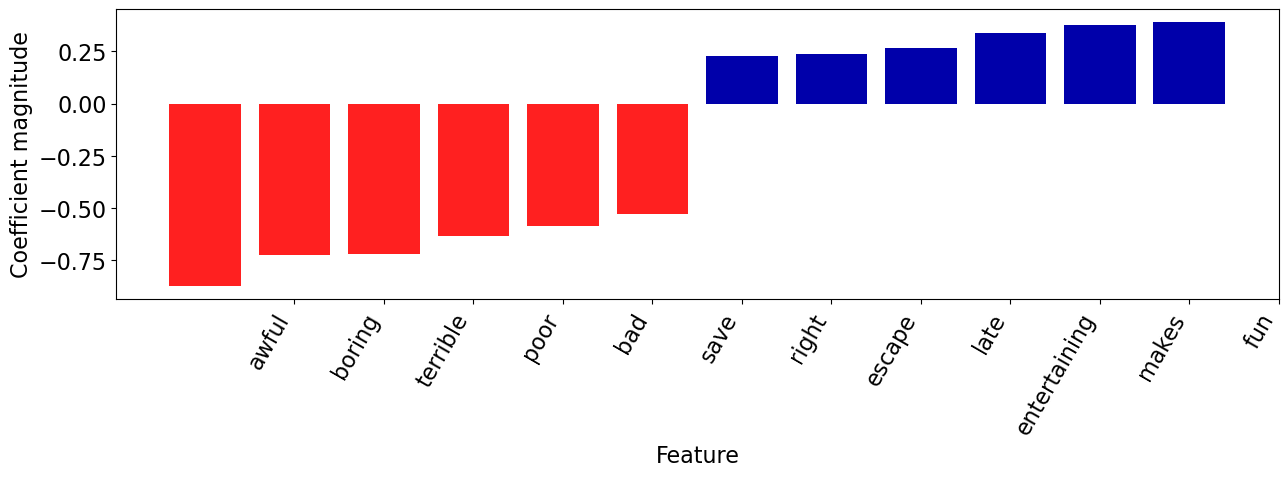

In [60]:
plot_coeff_example(pipe_lr, X_train.iloc[most_negative_id], coeffs, feature_names)

The review has both positive and negative words but the words with negative coefficients win in this case! 

## ❓❓ Questions for you

#### Question for you to ponder on 

- Is it possible to identify most important features using $k$-NNs? What about decision trees?  
